In [1]:
"""
Python matplotlib
Make scatter plots of ToE/noise hist+RCP85 vs. histNat (or Picontrol) in all 5 domains
>1std or >2std
"""

import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
from netCDF4 import Dataset as open_ncfile
import sys
sys.path.append('/home/ysilvy/Density_bining/Yona_analysis/programs/')
from maps_matplot_lib import defVarmme
from modelsDef import defModels, modelcolors
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import glob
import os
import datetime

# ----- Work -----

# Directory
indir_rcphn = '/home/ysilvy/Density_bining/Yona_analysis/data/toe_rcp85_histNat_average_signal/'
indir_rcppiC = '/home/ysilvy/Density_bining/Yona_analysis/data/toe_rcp85_PiControl_average_signal/'
indir_noise = '/home/ysilvy/Density_bining/Yona_analysis/data/noise_estimate/RCP85vshistNat_domains/'

models = defModels()

domains = ['Southern ST', 'SO', 'Northern ST', 'North Atlantic', 'North Pacific']

varname = defVarmme('salinity'); v = 'S'

method = 'average_signal' # Average signal and noise in the box, then compute ToE

# === INPUTS ===

# method_noise_rcphn = 'average_std' # Average the standard deviation of histNat in the specified domains
method_noise_rcp = 'average_histNat' # Average histNat in the specified domains then determine the std of this averaged value

use_piC = False # signal = hist+RCP - histNat, noise = std(histNat)
# use_piC = True # signal = hist+RCP - PiControl, noise = std(PiControl)

if use_piC == True and method_noise_rcp == 'average_histNat':
    method_noise_rcp = 'average_piC' # Just change the notation for coherence and for data path

# runs_rcp = 'same' # Same runs (30 runs) for hist+RCP8.5 vs. histNat as for hist+RCP8.5 vs. PiControl
runs_rcp = 'all' # All runs (35)

multstd = 2 # ToE >1std or >2std

# output format
# outfmt = 'view'
outfmt = 'save'

# ===========

# ----- Variables ------
var = varname['var_zonal_w/bowl']
legVar = varname['legVar']
unit = varname['unit']

# ----- Read ToE and noise for each model ------

# == Historical + RCP8.5 vs. historicalNat or vs. PiControl ==

nruns = 0 # Initialize total number of runs
nrunmax = 100

# -- Initialize varToE containing ToE of all runs
varToEA = np.ma.masked_all((nrunmax, len(domains)))
varToEP = np.ma.masked_all((nrunmax, len(domains)))
varToEI = np.ma.masked_all((nrunmax, len(domains)))

# -- Initialize noise
varnoiseA = np.ma.masked_all((nrunmax, len(domains)))
varnoiseP = np.ma.masked_all((nrunmax, len(domains)))
varnoiseI = np.ma.masked_all((nrunmax, len(domains)))

# -- Loop over models
if use_piC == True:
    indir = indir_rcppiC
else:
    indir = indir_rcphn
if v=='S':
    listfiles = glob.glob(indir + method_noise_rcp + '/*'+legVar+'_toe*.nc')
listfiles = sorted(listfiles)
nmodels = len(listfiles)
nMembers = np.ma.zeros(len(models),dtype='int') # Initialize array for keeping number of members per model
names = ['']*nmodels # Initialize array for keeping names of models

for i in range(nmodels):

    file_toe = listfiles[i]
    ftoe = open_ncfile(file_toe, 'r')
    name = os.path.basename(file_toe).split('.')[1]

    # If use same runs in vs. histNat as in vs. PiControl, take out deficient models
    if (runs_rcp == 'all') or (runs_rcp =='same' and name != 'GISS-E2-R' and name != 'FGOALS-g2' and name != 'MIROC-ESM'):

        # Read ToE (members, basin, domain)
        if multstd == 1:
            toeread = ftoe.variables[var + 'ToE1'][:]
        else:
            toeread = ftoe.variables[var + 'ToE2'][:]
        nMembers[i] = int(toeread.shape[0])
        print('- Reading ToE of %s with %d members'%(name,nMembers[i]))
        nruns1 = int(nruns + nMembers[i])

        # Save ToE
        varToEA[nruns:nruns1,:] = toeread[:,1,:]
        varToEP[nruns:nruns1,:] = toeread[:,2,:]
        varToEI[nruns:nruns1,:] = toeread[:,3,:]

        # Read and save noise
        filenoise = 'cmip5.' + name + '.noise_domains_hist_histNat.std_of_average.nc'
        fnoise = open_ncfile(indir_noise + filenoise,'r')
        if use_piC:
            varstd = fnoise.variables[var+'stdpiC'][:]
            varnoiseA[nruns:nruns1,:] = varstd[1,:]
            varnoiseP[nruns:nruns1,:] = varstd[2,:]
            varnoiseI[nruns:nruns1,:] = varstd[3,:]
        else:
            varstd = fnoise.variables[var+'stdhn'][:]
            varnoiseA[nruns:nruns1,:] = np.ma.max(varstd[:,1,:], axis=0)
            varnoiseP[nruns:nruns1,:] = np.ma.max(varstd[:,2,:], axis=0)
            varnoiseI[nruns:nruns1,:] = np.ma.max(varstd[:,3,:], axis=0)

        nruns = nruns1

        names[i] = name


print('Total number of runs:', nruns)
varToEA = varToEA[0:nruns,:]
varToEP = varToEP[0:nruns,:]
varToEI = varToEI[0:nruns,:]
varnoiseA = varnoiseA[0:nruns,:]
varnoiseP = varnoiseP[0:nruns,:]
varnoiseI = varnoiseI[0:nruns,:]


nruns = int(nruns)

if use_piC == False and runs_rcp == 'same':
        nmodels=nmodels-3
        names = filter(None,names)
        nMembers = nMembers[np.ma.nonzero(nMembers)]

cumMembers = np.cumsum(nMembers)


- Reading ToE of CCSM4 with 6 members
- Reading ToE of CESM1-CAM5 with 3 members
- Reading ToE of CSIRO-Mk3-6-0 with 9 members
- Reading ToE of CanESM2 with 5 members
- Reading ToE of FGOALS-g2 with 1 members
- Reading ToE of GISS-E2-R with 3 members
- Reading ToE of HadGEM2-ES with 2 members
- Reading ToE of IPSL-CM5A-LR with 3 members
- Reading ToE of IPSL-CM5A-MR with 1 members
- Reading ToE of MIROC-ESM-CHEM with 1 members
- Reading ToE of MIROC-ESM with 1 members
Total number of runs: 35


In [2]:
maskdata = np.nan

## Models per region

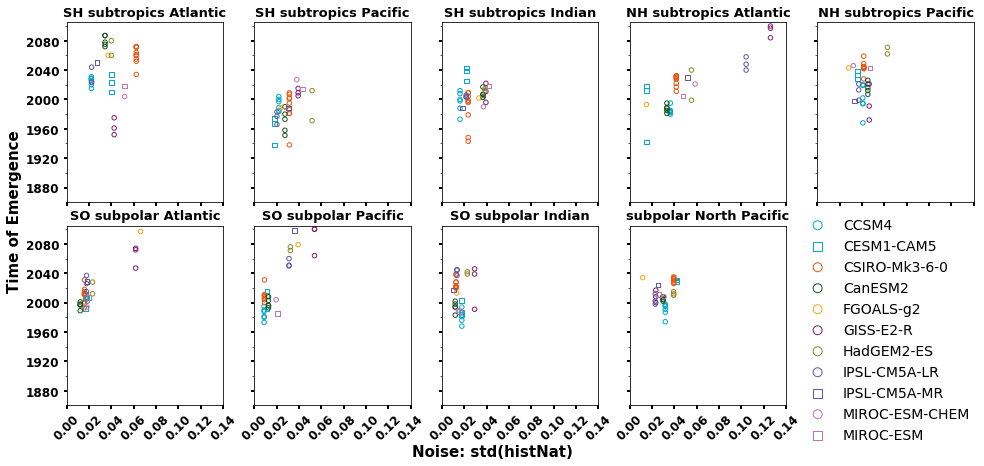

In [9]:
fig, axes = plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True,figsize=(15,7))

# Re-organize data
dataToE2 = np.array([varToEA[:,0], varToEP[:,0], varToEI[:,0], varToEA[:,3], varToEP[:,2], varToEA[:,1], varToEP[:,1], varToEI[:,1], varToEP[:,4]])

datanoise2 = np.array([varnoiseA[:,0], varnoiseP[:,0], varnoiseI[:,0], varnoiseA[:,3], varnoiseP[:,2], varnoiseA[:,1], varnoiseP[:,1], varnoiseI[:,1], varnoiseP[:,4]])

# New domain labels
domain_names2 = ['SH subtropics Atlantic', 'SH subtropics Pacific', 'SH subtropics Indian', 'NH subtropics Atlantic', 'NH subtropics Pacific', 'SO subpolar Atlantic','SO subpolar Pacific','SO subpolar Indian', 'subpolar North Pacific']


ax1D = axes.ravel().tolist()
l=['']*nmodels

for idomain in range(len(domain_names2)):

   ax = ax1D[idomain]
   l[0] = ax.scatter(datanoise2[idomain,0:cumMembers[0]],dataToE2[idomain,0:cumMembers[0]],color=modelcolors(names[0])['color'],
          s=20,facecolors='none',marker=modelcolors(names[0])['marker'], label=names[0])

   for i in range(1,nmodels):
       col = modelcolors(names[i])['color']
       mk = modelcolors(names[i])['marker']
       l[i] = ax.scatter(datanoise2[idomain,cumMembers[i-1]:cumMembers[i]],dataToE2[idomain,cumMembers[i-1]:cumMembers[i]],
                  s=20, color=col, facecolors='none', marker=mk, label=names[i])

   ax.set_title(domain_names2[idomain],fontsize=13,fontweight='bold')

   plt.setp(ax.get_xticklabels(), fontweight='bold', fontsize=12)
   plt.setp(ax.get_yticklabels(), fontweight='bold', fontsize=12)
   ax.xaxis.set_tick_params(which='major',width=2)
   ax.yaxis.set_tick_params(which='major',width=2)
    
   for tick in ax.get_xticklabels():
       tick.set_rotation(45)

title = 'Hist+RCP8.5 vs. histNat ('+str(nruns)+' runs)'
noise = 'histNat'
plotName = 'suppscatterplot_perregion'

ax.set_ylim([1860,2105])
ax.set_xlim([0,0.14])
ax.set_xticks(np.arange(0,0.1401,0.02))
xmajorLocator = MultipleLocator(40)
xminorLocator = AutoMinorLocator(2)
ax.yaxis.set_major_locator(xmajorLocator)
ax.yaxis.set_minor_locator(xminorLocator)


#plt.suptitle('ToE[>' +str(multstd)+ 'std]/noise for '+title+ ' in different regions', fontweight='bold', fontsize=14)

plt.figtext(0.38,0.02,'Noise: std('+noise+')', fontweight='bold',fontsize=15)
plt.figtext(0.005,0.35,'Time of Emergence', fontweight='bold', rotation='vertical',fontsize=15)

# Put a legend to the right of the current axis
lgd = fig.legend(l,names,loc='center right',bbox_to_anchor=(0.91, 0.27),scatterpoints=1,frameon=False, markerscale=2,fontsize=14)

plt.subplots_adjust(left=0.06,hspace=0.13,bottom=0.12) #,right=0.83,

fig.delaxes(axes[-1,-1])

plt.savefig(plotName+'.png', bbox_extra_artists=(lgd,),dpi=150)

## Regions per model 

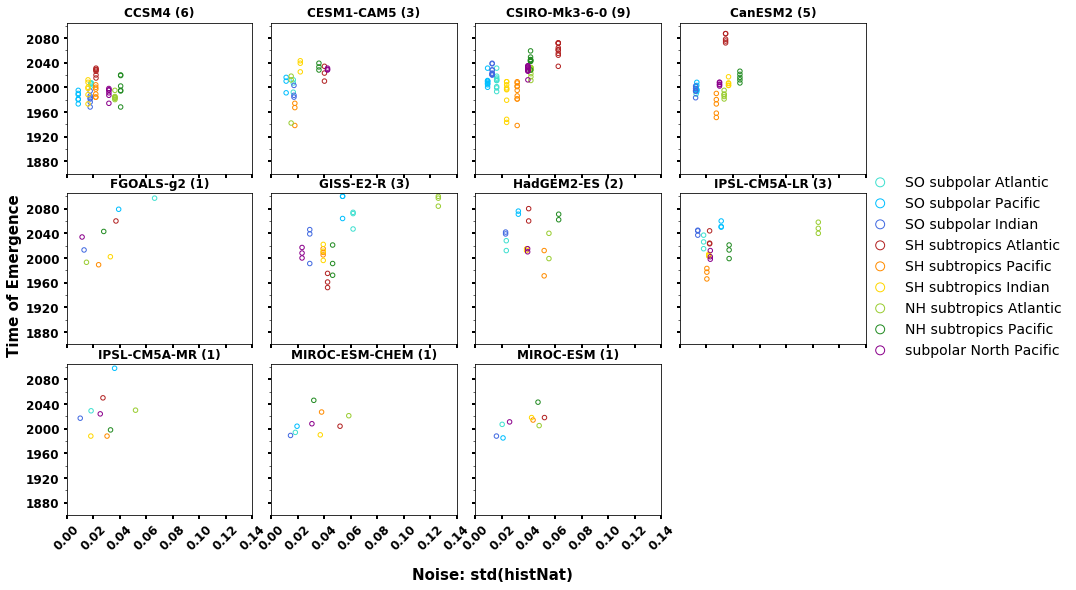

In [12]:
dataToE = np.array([varToEA[:,1], varToEP[:,1], varToEI[:,1], varToEA[:,0], varToEP[:,0], varToEI[:,0], varToEA[:,3], varToEP[:,2], varToEP[:,4]])

datanoise = np.array([varnoiseA[:,1], varnoiseP[:,1], varnoiseI[:,1], varnoiseA[:,0], varnoiseP[:,0], varnoiseI[:,0], varnoiseA[:,3], varnoiseP[:,2], varnoiseP[:,4]])

# New domain labels
domain_names = ['SO subpolar Atlantic','SO subpolar Pacific','SO subpolar Indian', 'SH subtropics Atlantic', 'SH subtropics Pacific', 'SH subtropics Indian', 'NH subtropics Atlantic', 'NH subtropics Pacific', 'subpolar North Pacific']

# Create figure
fig, axes = plt.subplots(nrows=3,ncols=4,sharex=True,sharey=True,figsize=(15,9))

domain_colors = ['turquoise','deepskyblue','royalblue','firebrick','darkorange','gold','yellowgreen','forestgreen','darkmagenta']

ax1D = axes.ravel().tolist()
l=['']*len(domain_names)

for imodel in range(len(ax1D)-1):
    ax = ax1D[imodel]
    
    for idomain in range(len(domain_names)):
        col = domain_colors[idomain]
        if imodel ==0:
            ax.scatter(datanoise[idomain,0:cumMembers[0]],dataToE[idomain,0:cumMembers[0]],color=col,s=20,facecolors='none', label=domain_names[idomain])
        else:
            l[idomain] = ax.scatter(datanoise[idomain,cumMembers[imodel-1]:cumMembers[imodel]],dataToE[idomain,cumMembers[imodel-1]:cumMembers[imodel]],color=col, s=20,facecolors='none', label=domain_names[idomain])

    ax.set_title(names[imodel] + ' ('+str(int(nMembers[imodel]))+')',fontsize=12,fontweight='bold')
    
    plt.setp(ax.get_xticklabels(), fontweight='bold', fontsize=12)
    plt.setp(ax.get_yticklabels(), fontweight='bold', fontsize=12)
    ax.xaxis.set_tick_params(which='major',width=2)
    ax.yaxis.set_tick_params(which='major',width=2)
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)


title = 'Hist+RCP8.5 vs. histNat ('+str(nruns)+' runs)'
noise = 'histNat'
plotName = 'suppscatterplot_permodel'


ax.set_ylim([1860,2105])
ax.set_xlim([0,0.14])
ax.set_xticks(np.arange(0,0.1401,0.02))
xmajorLocator = MultipleLocator(40)
xminorLocator = AutoMinorLocator(2)
ax.yaxis.set_major_locator(xmajorLocator)
ax.yaxis.set_minor_locator(xminorLocator)

fig.delaxes(axes[-1,-1])

plt.figtext(0.38,0.02,'Noise: std('+noise+')', fontweight='bold',fontsize=15)
plt.figtext(0.005,0.37,'Time of Emergence', fontweight='bold', rotation='vertical',fontsize=15)

# Put a legend to the right of the current axis
lgd = fig.legend(l,domain_names,loc='center right', bbox_to_anchor=(0.995, 0.5), scatterpoints=1,frameon=False, markerscale=2,fontsize=14)

plt.subplots_adjust(left=0.06,right=0.8,hspace=0.13,wspace=0.1,bottom=0.12)
    
plt.savefig(plotName+'.png',bbox_extra_artists=(lgd,), dpi=150)